# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Read in the temperature and humidity data set

In [3]:
df = pd.read_csv("train_humidity_temp.csv")

In [4]:
df.head()

,temp,humidity
0,9.84,81
1,9.02,80
2,9.02,80
3,9.84,75
4,9.84,75


# Function to calculate the Euclidean distance between each data point and each centroid, and assign the data point to the closest cluster

In [5]:
def find_closest_centroid(row, centroids, centroid_to_row_num):
    closest_distance = 999999
    closest_centroid = 99
    
    for i, centroid_vector in enumerate(centroids):
        current_distance = np.sqrt(np.power((row['temp'] - centroid_vector[0]), 2) + np.power((row['humidity'] - centroid_vector[1]), 2))
        if (current_distance < closest_distance):
            closest_distance = current_distance
            closest_centroid = i
    
    centroid_to_row_num[closest_centroid].append((row['temp'], row['humidity']))
    
    return row

# Function to calculate the average within-cluster sum-of-squared error

In [26]:
def calc_within_cluster_sse(num_clusters):
    # Select num_clusters worth of random points to initialize as the centroid mean
    centroids = []
    for i in range(0, num_clusters):
        centroids.append((df.iloc[np.random.randint(0, df.shape[0])]['temp'], df.iloc[np.random.randint(0, df.shape[0])]['humidity']))
    
    # Initialize a dictionary of K lists to store the points that map to the closest centroid
    centroid_to_row_num = {}

    for each_cluster_index in range(0, num_clusters):
        centroid_to_row_num[each_cluster_index] = []
    
    # Assign the data points to the nearest cluster
    df.apply(find_closest_centroid, args=(centroids, centroid_to_row_num,), axis=1)
    
    # Calculate the average within-cluster sum-of-squared errors across all clusters
    avg_within_cluster_sse = 0
    for each_cluster_index in centroid_to_row_num:
        avg_within_cluster_sse += np.sum(
            np.sqrt(
                [(np.power(x[0] - centroids[each_cluster_index][0], 2) + np.power(x[1] - centroids[each_cluster_index][1], 2)) for x in centroid_to_row_num[each_cluster_index]]
            )
        )
    avg_within_cluster_sse /= len(centroids)
    
    return avg_within_cluster_sse
    

# Use the elbow method on the average sum-of-squared errors across clusters to find the optimal K for the number of clusters

In [72]:
num_clusters = 20

In [73]:
cluster_index_to_sse_dict = {}
for i in range(1, num_clusters + 1):
    cluster_index_to_sse_dict[i] = calc_within_cluster_sse(i)

In [33]:
cluster_index_to_sse_dict

{1: 306411.91951916704,
 2: 121329.18340294158,
 3: 41526.851624379684,
 4: 29345.191238582836,
 5: 20251.02440143549,
 6: 20897.95720883185,
 7: 13665.635549928817,
 8: 11264.554641522263,
 9: 9958.259782832869,
 10: 8391.432765918118,
 11: 8308.590495970146,
 12: 6841.039237943071,
 13: 5711.578517742162,
 14: 4288.048209648035,
 15: 4384.185234649916}

# Plot the sum-of-squared errors against the number of clusters

Text(0,0.5,'Sum-of-squared Errors')

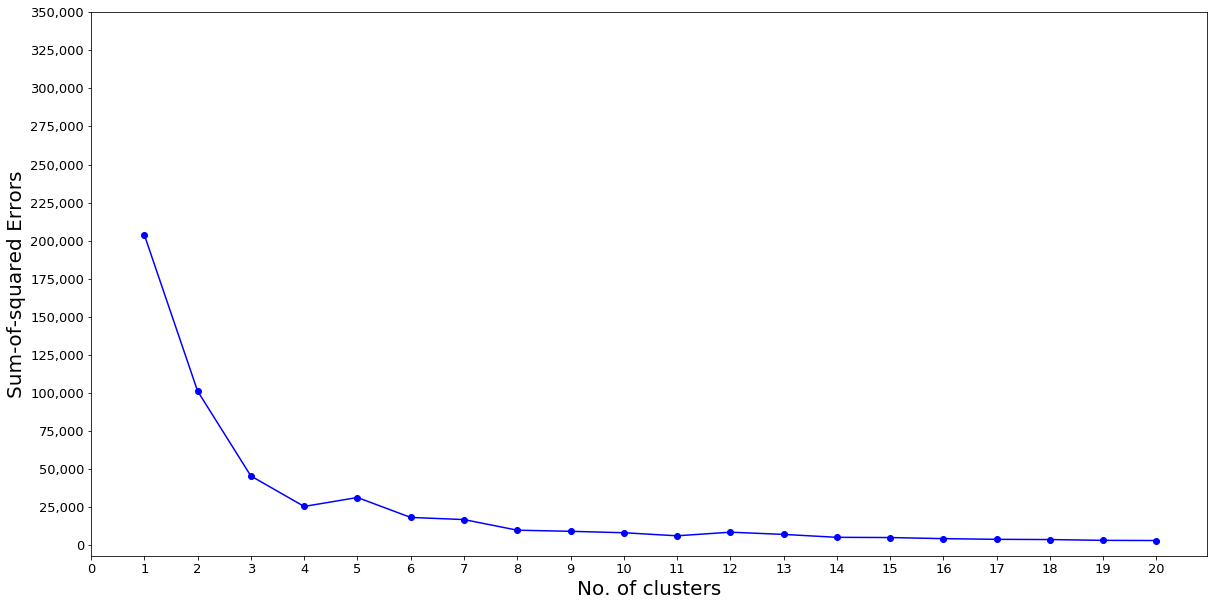

In [74]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(
    [x for x in cluster_index_to_sse_dict], 
    [cluster_index_to_sse_dict[x] for x in cluster_index_to_sse_dict], 
    'o', 
    color='blue',
    linestyle='-'
)
x_start, x_end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, num_clusters + 1, 1))
ax.yaxis.set_ticks(np.arange(0, 350001, 25000))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('No. of clusters', fontsize=20)
ax.set_ylabel('Sum-of-squared Errors', fontsize=20)

# Selecting K random data points to be the initial cluster centroids

In [6]:
num_clusters = 4

# The data points for the cluster centroids are in the form: (temp, humidity)

In [7]:
centroids = []
for i in range(0, num_clusters):
    centroids.append((df.iloc[np.random.randint(0, df.shape[0])]['temp'], df.iloc[np.random.randint(0, df.shape[0])]['humidity']))

In [8]:
centroids

[(17.22, 53.0), (20.5, 40.0), (23.78, 62.0), (14.76, 59.0)]

# Initialize a dictionary of K lists to store the points that map to the closest centroid

In [9]:
centroid_to_row_num = {}

for each_cluster_index in range(0, num_clusters):
    centroid_to_row_num[each_cluster_index] = []

In [10]:
df.apply(find_closest_centroid, args=(centroids, centroid_to_row_num,), axis=1)

,temp,humidity
0,9.84,81.0
1,9.02,80.0
2,9.02,80.0
3,9.84,75.0
4,9.84,75.0
5,9.84,75.0
6,9.02,80.0
7,8.20,86.0
8,9.84,75.0
9,13.12,76.0


# Plot the initial clusters and data points on a scatterplot

Text(0,0.5,'Humidity')

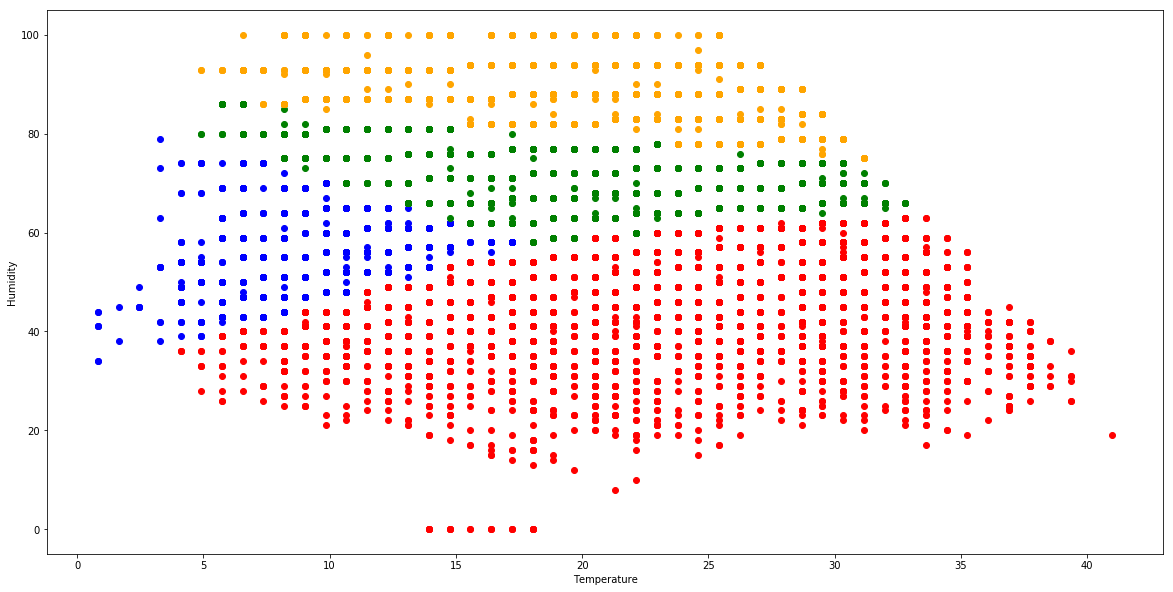

In [80]:
graph_point_colors = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta', 'pink', 'black', 'plum', 'yellowgreen']
plt.figure(figsize=(20,10))
for i in range(0, num_clusters):
    plt.plot([x[0] for x in centroid_to_row_num[i]], [x[1] for x in centroid_to_row_num[i]], 'o', color=graph_point_colors[i])
plt.xlabel('Temperature')
plt.ylabel('Humidity')

# Calculate the new centroid means

In [81]:
for cluster_centroid_index in centroid_to_row_num:
    centroids[cluster_centroid_index] = (np.mean([x[0] for x in centroid_to_row_num[cluster_centroid_index]]), np.mean([x[1] for x in centroid_to_row_num[cluster_centroid_index]]))

In [82]:
centroids

[(23.08173774230331, 43.70399087799316),
 (9.927474600870829, 56.879535558780844),
 (20.358177063877474, 71.04632050803137),
 (20.780817327339598, 87.27584797711484)]

# Re-calculate the Euclidean distance between each point and the new cluster centroids

In [83]:
df.apply(find_closest_centroid, args=(centroids, centroid_to_row_num,), axis=1)

,temp,humidity
0,9.84,81.0
1,9.02,80.0
2,9.02,80.0
3,9.84,75.0
4,9.84,75.0
5,9.84,75.0
6,9.02,80.0
7,8.20,86.0
8,9.84,75.0
9,13.12,76.0


# Plot the new clusters and data points

Text(0,0.5,'Humidity')

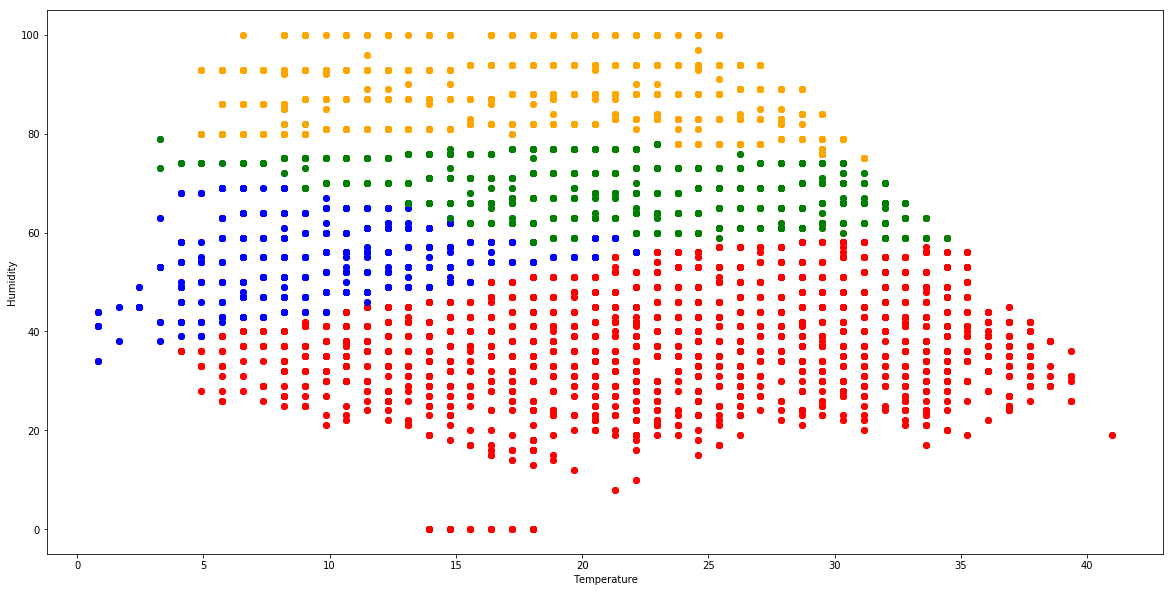

In [84]:
graph_point_colors = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta', 'pink', 'black', 'plum', 'yellowgreen']
plt.figure(figsize=(20,10))
for i in range(0, num_clusters):
    plt.plot([x[0] for x in centroid_to_row_num[i]], [x[1] for x in centroid_to_row_num[i]], 'o', color=graph_point_colors[i])
plt.xlabel('Temperature')
plt.ylabel('Humidity')

# For the next 5 iterations, repeat the new centroid re-calculation, cluster grouping for each data point, and plot the adjusted clusters and data points

In [11]:
num_iterations = 100

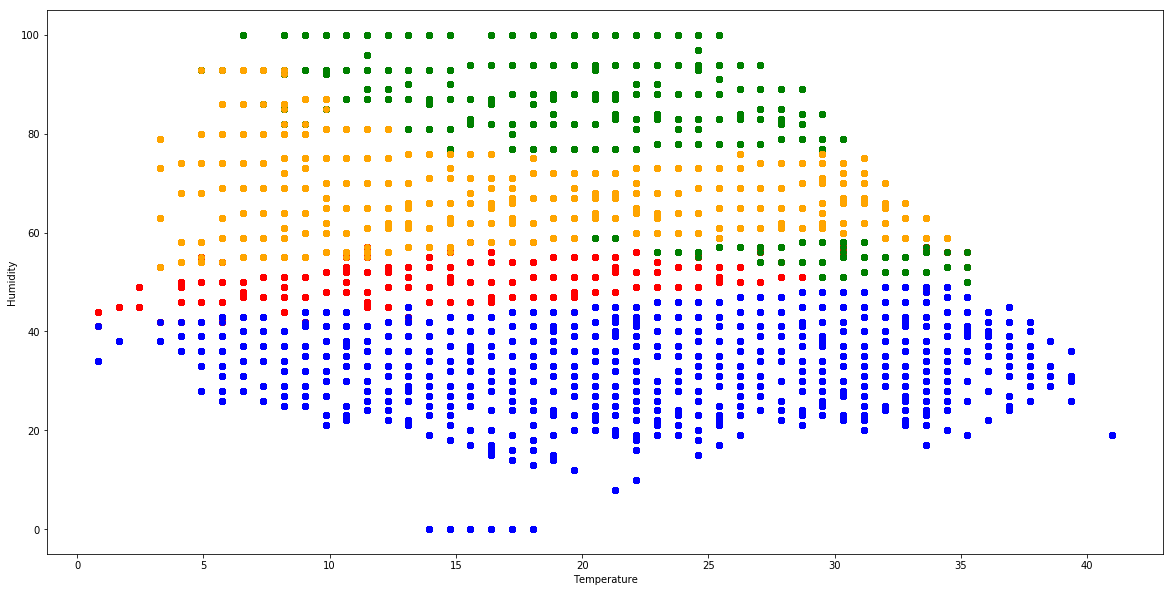

In [13]:
for i in range(0, num_iterations):
    # Re-calculate the new cluster centroid
    for cluster_centroid_index in centroid_to_row_num:
        centroids[cluster_centroid_index] = (np.mean([x[0] for x in centroid_to_row_num[cluster_centroid_index]]), np.mean([x[1] for x in centroid_to_row_num[cluster_centroid_index]]))
    
    # Re-calculate the distance between each point and the new cluster centroid,
    # assigning them a new cluster grouping if necessary
    df.apply(find_closest_centroid, args=(centroids, centroid_to_row_num,), axis=1)
    
    # Plot the new adjusted cluster(s) and data point(s)
#     graph_point_colors = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta', 'pink', 'black', 'plum', 'yellowgreen']
#     plt.figure(figsize=(20,10))
#     for i in range(0, num_clusters):
#         plt.plot([x[0] for x in centroid_to_row_num[i]], [x[1] for x in centroid_to_row_num[i]], 'o', color=graph_point_colors[i])
#     plt.xlabel('Temperature')
#     plt.ylabel('Humidity')

graph_point_colors = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta', 'pink', 'black', 'plum', 'yellowgreen']
plt.figure(figsize=(20,10))
for i in range(0, num_clusters):
    plt.plot([x[0] for x in centroid_to_row_num[i]], [x[1] for x in centroid_to_row_num[i]], 'o', color=graph_point_colors[i])
    plt.xlabel('Temperature')
    plt.ylabel('Humidity')